In [1]:
from classes.QCircuits import *
from classes.QnnTorchConnector import *
from classes.CsvDataset import *
from classes.Utils import *

from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import SPSA, SLSQP, L_BFGS_B, COBYLA

import numpy as np
from math import log
from pandas import read_csv, DataFrame, concat

import matplotlib.pyplot as plt

import torch as T

from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split

c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key[i] is '0':
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key[measuring_qubit] is '0':
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:158: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.post_process is "parity":
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:160: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.post_process is "probabilities_per_qubit":
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:162: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.post_process is "measure_one_qubit":
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:170: SyntaxWarni

error =  'Invalid option devices'


In [2]:
seed = 42
np.random.seed(seed)
T.manual_seed(seed)

# BANKNOTE DATASET. 
# define the location of the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/banknote_authentication.csv'
n=2

dataset_name = 'banknote'
save_path = 'loss_data/'+dataset_name+'_'

df = read_csv(url, header=None)
print(df.describe())   
epochs = 15


dataset = CsvDataset(df=df, features=(0,2), target=4)

train_dl, test_dl = create_train_test_dataloader(dataset, batch_size=10)

                 0            1            2            3            4
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000


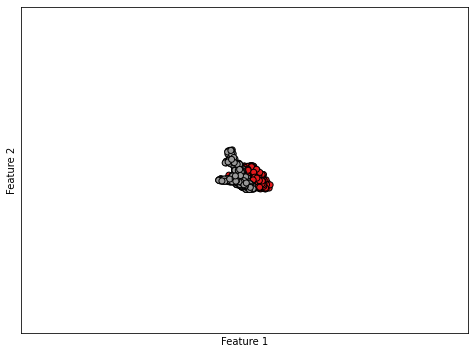

In [3]:
# only plots two features
# plot_two_features_classification(df.iloc[:,0],df.iloc[:,2], df.iloc[:,4], 'figures/'+dataset_name+'.png')
plot_two_features_classification(dataset.X[:,0],dataset.X[:,1], dataset.y)

In [4]:
cnn1, cnn2 = create_cnn_and_fit_and_store_result(save_path, dataset, n, epochs)

--------create model-----------
param count is : 15
test_dl_is_not None
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
test_dl_is_not None
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Using backend
Not Usin

In [5]:
def create_qnn_and_fit_and_store_result_(save_path, circuit_type, dataset, n, epochs,
                                        batch_size=10, loss_obj=T.nn.BCELoss(), test_size=0.2, lrn=0.05):

    print("--------create model-----------")

    circuit1 = CircuitFactory().provide(circuit_type, n)
    qnn1 = QnnTorchConnector(Qnn(circuit1))

    print("param count is :", count_parameters(qnn1))

    train_dl, test_dl = create_train_test_dataloader(dataset, batch_size=batch_size, test_size=test_size)

    loss_array, _, acc_array = train_on_dl_(qnn1, train_dl, test_dl, epochs=epochs,
                                           loss_obj=loss_obj, optimizer=T.optim.Adam(qnn1.parameters(), lr=lrn))

    np.save(save_path + circuit_type + '_bs' + str(batch_size) + '_loss.npy', loss_array)
    np.save(save_path + circuit_type + '_bs' + str(batch_size) + '_accuracy.npy', acc_array)
    print("--------end fitting-----------\n")

    return qnn1

def train_on_dl_(model, train_loader, test_dl=None, epochs=100, optimizer=None,
                verbose=0, loss_obj=T.nn.BCELoss()):
    loss_list_val = []
    loss_list_train = []
    acc_list_val = []

    if optimizer is None:
        optimizer = T.optim.Adam(model.parameters(), lr=0.1)

    for epoch in range(epochs):
        total_loss = []
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.type(T.DoubleTensor)

            # Forward pass
            output = model(data)
            target = T.reshape(target, [1, -1])
            output = T.reshape(output, [1, -1])
            # print(output)
            # print(target)

            # Calculating loss
            loss = loss_obj(output, target)
            # print("loss:", loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())

        epoch_train_loss = sum(total_loss) / len(total_loss)
        loss_list_train.append(epoch_train_loss)

        if verbose == 1:
            print("training loss for epoch ", epoch, " is :", loss_list_val[-1])
        if test_dl is not None:
            model.eval()
            val_loss, val_accuracy = eval_on_dataloader_(model, test_dl, loss_obj)
            loss_list_val.append(val_loss)
            acc_list_val.append(val_accuracy)

    print("end of run - train loss array is:", loss_list_train)
    print("end of run - val loss array is:", loss_list_val)
    if val_accuracy is not None:
        print("end of run - val accuracy is:", acc_list_val)

    return loss_list_val, loss_list_train, acc_list_val


def eval_on_dataloader_(model, data_loader, loss_obj=T.nn.BCELoss()):  # TODO inefficient as it predicts twice...
    loss = compute_loss_(model, data_loader, loss_obj)
    acc = accuracy_(model, data_loader)
    return loss, acc


def compute_loss_(model, dataloader, loss_obj=T.nn.BCELoss()):
    total_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        if isinstance(model.qnn, Qnn):
            print("Using backend")
            output = T.tensor(model.qnn.predict_with_backend(inputs))
        else:
            print("Not Using backend")
            output = model(inputs)
        target = T.reshape(targets, [1, -1])
        output = T.reshape(output, [1, -1])
        total_loss += loss_obj(output, target).item() / len(dataloader)
    return total_loss


def accuracy_(model, dataloader):
    acc = 0
    for i, (inputs, targets) in enumerate(dataloader):
        if isinstance(model, Qnn):
            output = T.tensor(model.predict_with_backend(inputs))
        else:
            output = model(inputs)
        output = T.reshape(output, [1, -1])
        targets = T.reshape(targets, [1, -1])
        acc += T.sum(T.round(output) == T.round(targets)).numpy() / len(dataloader.dataset)
    return acc

create_qnn_and_fit_and_store_result_(save_path, circuit_type="ZzFeatureMapRealAmplitudeCircuit", dataset=dataset, n=n, epochs=epochs)

create_qnn_and_fit_and_store_result_(save_path, circuit_type="CombinedQnn", dataset=dataset, n=n, epochs=epochs)


--------create model-----------
param count is : 4


c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:268: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  predictions = T.tensor([np.array(result)])


Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using backend
Using 

c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key[i] is '0':
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key[measuring_qubit] is '0':
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:158: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.post_process is "parity":
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:160: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.post_process is "probabilities_per_qubit":
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:162: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.post_process is "measure_one_qubit":
c:\Programs\pc\Python\tcc\Testing_Quantum_Neural_Net\classes\QnnTorchConnector.py:170: SyntaxWarni

KeyboardInterrupt: 

In [6]:
create_qnn_and_fit_and_store_result(save_path, circuit_type="ZzFeatureMapRealAmplitudeCircuit", dataset=dataset, n=n, epochs=epochs)

create_qnn_and_fit_and_store_result(save_path, circuit_type="CombinedQnn", dataset=dataset, n=n, epochs=epochs)


--------create model-----------
param count is : 4


KeyboardInterrupt: 

In [ ]:
create_hybridqnn_and_fit_and_store_result_(save_path, "ZzFeatureMapRealAmplitudeCircuit", dataset, n, epochs)

create_hybridqnn_and_fit_and_store_result_(save_path, "CombinedQnn", dataset, n, epochs)
    

--------create model-----------
param count is : 7


KeyboardInterrupt: 

In [ ]:
# import qiskit
# qiskit.__qiskit_version__